In [1]:
import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn import linear_model, decomposition, datasets, metrics

from sklearn.tree import DecisionTreeClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn
import skl2onnx as sklo

import onnxruntime as rt


from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

In [3]:
public_data = pd.read_csv('data_public.csv')


## Abstract - Research summary, findings, and next steps

I found through investigation of the data that a lot of the columns are directly or indirectly correlated with the class. The contigency tables for N and O especially with the Class have 100% fscore, 100% recall, and 100% precision. N and O's correlation with most of the other 14 features is high. Thus by taking out completely correlated features I can reduce the dimensionality of the data. The other way I was thinking of reducing dimesionality is by doing PCA. Using this method identifies that 97% of the variance lies within the 1st and 2nd components. Thus we can reduce dimensionality from 16 to 2 features. Using the data we were given with a 30/70 split I can get a 100% prediction rate for using PCA and a RandomForest. The model makes an assumption that population data will have similar variance to the sample data. Thus reducing dimensionality with PCA and then putting it in a random forest will provide a good estimation of the classes. The model is trained on a k-fold validation that provides the best fscores for the model. Fscore is used because it provides a more complete picture as compared to recall or precision alone. Scaling doesn't achieve much. PCA performed with 2 components gives 100% recall, precision, accuracy, and fscore. This is because the first 2 components capture all of the variance. In this case since most fo the columns are correlated the variance will be correlated with class. This can be seen in the k-fold cross-validation. Specifically when I use the first 2 components of PCA. This allows the model to achieve a 100% true positive rate while reducing the false positive rate to 0%. This seems very fishy but its mainly due to the correlations between the class and the other features. The k-fold validation does seem to show that even on outside data the model is at 100%. This could again be attributed to biases in the data as the data is to homogenous with the target feature. The next steps is to test the model on an outside dataset and get an idea about the biases found inside the given data.

## Overview - Problem statement, relevant literature, proposed methodology
The problem statement is to make a model that is able to indentify the target in the dataset very accurately. Considering that this is a classification problem Tan's chapter on classifier would play an important role in developing this model. A decision tree classifier is a main part of the strategy because this was the clasifier that was most discussed in class. The other reason that decision tree classifiers were considered were the great results that they produced in identifying the classes probably. 


In [4]:
public_data.describe()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
count,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,5.068656e+01,-1.883373e+01,7.162152e+01,-1.355120e+01,2.944177e+01,-6.185189e+00,3.174186e+01,5.112504e+01,3.300077e+01,4.092546e+01,7.938340e+01,-6.746540e+00,-4.232290e+01,4.949012e+01,5.980333e+01,2.166636e+00
std,1.292492e+02,1.446355e+01,1.052808e+02,4.689774e+01,7.282278e+01,7.309100e+01,6.660329e+01,1.034053e+02,4.217119e+01,7.694386e+01,9.484003e+01,1.557490e+01,1.791142e+01,6.728231e+01,6.677712e+01,6.872945e-01
min,-7.308940e+01,-8.322357e+01,-5.972853e+01,-1.375818e+02,-3.829826e+01,-1.485917e+02,-6.654137e+01,-4.246089e+01,-1.818542e+01,-1.123844e+02,-1.415233e+01,-6.271828e+01,-8.144988e+01,-2.057979e+01,-1.283059e+01,1.000000e+00
25%,-3.793679e+01,-1.786669e+01,7.553164e+00,-1.471337e+01,-2.436286e+01,-3.072492e+01,-3.484185e+00,-2.629661e+01,-7.594991e+00,2.108044e+01,2.419273e+00,-8.875128e+00,-5.567326e+01,-7.131906e+00,1.628438e-01,2.000000e+00
50%,-3.197847e+01,-1.369876e+01,1.348796e+01,-8.004308e+00,-1.897058e+01,-2.475391e+01,1.491431e+00,-1.817028e+01,3.769369e+01,2.717432e+01,2.652955e+01,-1.079123e+00,-5.297585e+01,1.462293e+01,4.689262e+01,2.000000e+00
75%,2.280020e+02,-1.055606e+01,2.123439e+02,1.955806e+01,1.289018e+02,7.834417e+01,1.151840e+02,1.915891e+02,7.984842e+01,1.253846e+02,2.046458e+02,3.334451e+00,-2.208504e+01,1.363603e+02,1.451293e+02,3.000000e+00
max,2.687738e+02,4.460108e+00,2.561698e+02,3.263799e+01,1.579843e+02,1.229186e+02,1.660534e+02,2.329496e+02,1.112970e+02,1.755397e+02,2.598003e+02,2.159496e+01,1.032828e+01,1.789303e+02,1.807011e+02,3.000000e+00


In [23]:
public_data.head(25)

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,3
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,2
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,3
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,3
5,235.027198,-16.081132,213.391582,-12.934912,122.413766,80.222540,125.240412,185.694965,66.072251,142.555417,213.442083,0.728989,-26.046291,137.529415,143.348783,3
6,-35.819795,-16.688245,5.738227,17.570011,-31.523595,-20.625764,0.077354,-28.944922,-10.699215,26.982097,2.958726,-2.365574,-56.082634,-6.918042,-0.996789,2
7,-28.620633,-16.324678,6.614499,19.866385,-23.119998,-22.328572,1.477065,-26.383605,-8.616671,28.874319,1.743714,4.953251,-55.702022,-8.014284,2.449081,2
8,-41.092898,-11.525839,12.027010,18.670988,-19.612979,-25.918632,5.266337,-25.972718,-13.371210,25.709532,-1.515002,-1.041023,-54.683633,-12.382565,5.424004,2
9,222.645628,-10.907163,215.098599,-15.552786,126.227053,85.659915,106.932482,195.793702,79.786718,138.150287,223.018301,-11.896866,-15.113817,146.038066,140.611871,3


## Data Processing - Pipeline details, data issues, assumptions/adjustments / Data Analysis - Summary statistics, visualization, feature extraction.
The first two observations in the data are the high dimensionality of the data and the high correlation between most of the features and the class. Dimensionality reduction is an important part of preprocessing. Given that 12 of the 16 features correlate strongly with the class we can afford to remove most of them. Most of the features in the dataset can be used to determine the class by simple filtering. Most of the features have ranges that map to specific classes. This is probably unique to the dataset and not charsteristic of the overall population. The other observation is that most of the features are correlated with each other. In fact there is only 4 features that have lower correlation with each other. Those are A B D I. These 4 features have less than 0.85 correalation score. The rest of the features are correlated by more than 0.9. 
This overlap in data means that I have to perform dimesionality reduction. In order to achieve thes I will be using PCA. Plotting the PCA I can see that the first two principal components explain about 99% of the variance of the dataset. If we assume that the general population has a similar variance to out dataset than we can generalize our model by using variance to predict the classes of the objects. For this dataset a PCA transformation with 2 components would be very effective but in order to generalize the model I will be using twice the components and include 4 components. This will still reduce the dimensionality by 4 times but will generalize the model.   


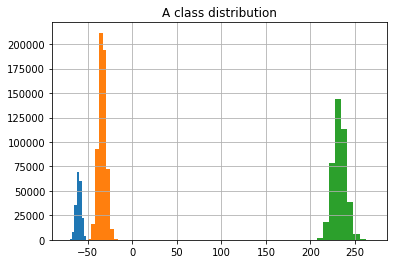

None


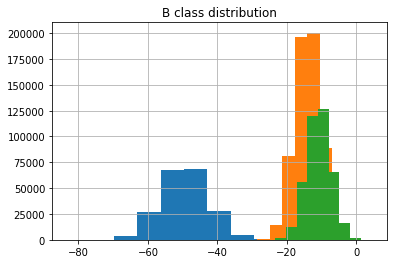

None


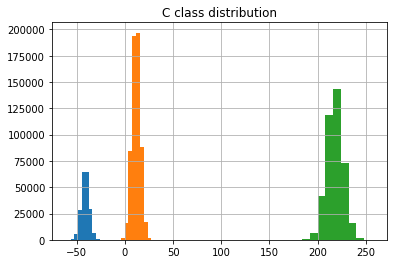

None


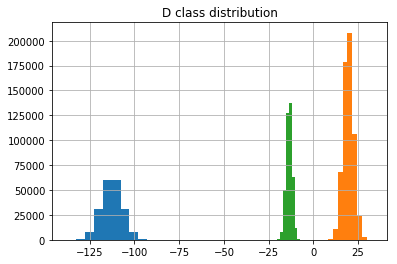

None


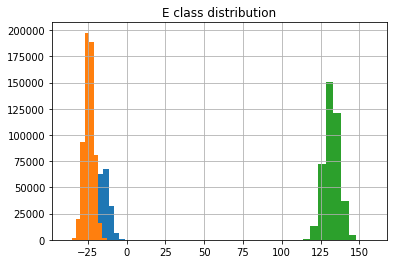

None


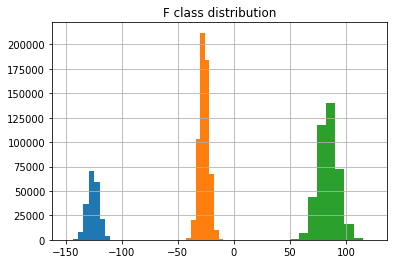

None


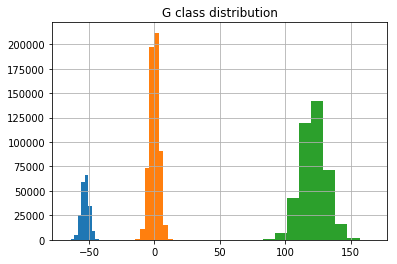

None


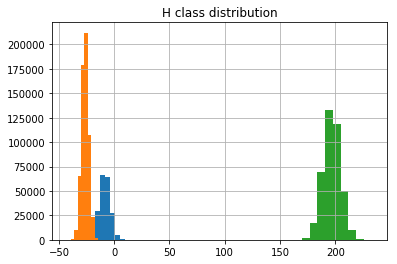

None


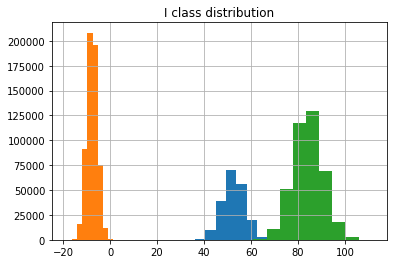

None


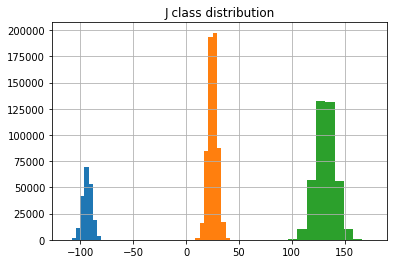

None


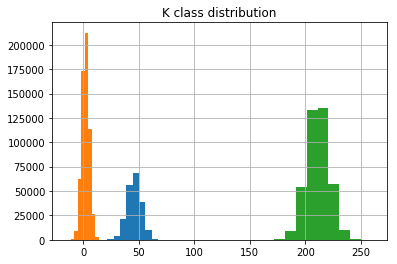

None


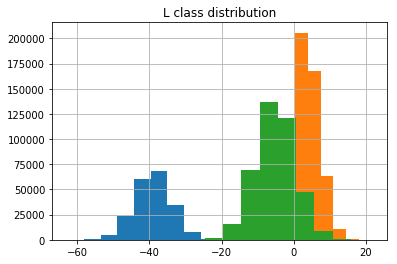

None


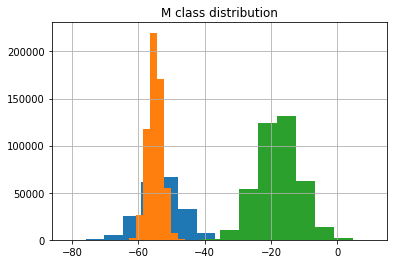

None


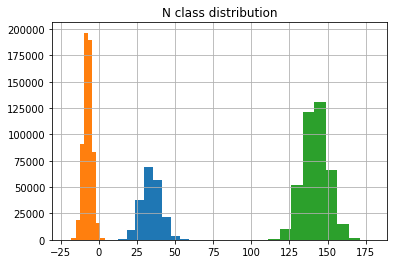

None


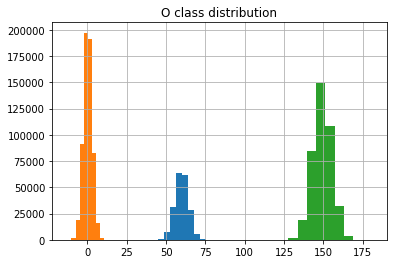

None


In [15]:
for feature in public_data.drop(columns="Class").columns:
    public_data.groupby("Class")[feature].hist()
    plt.title(feature+ " class distribution")
    print(plt.show())



In [30]:
np_values = public_data.values
standard_scaler = StandardScaler()
vals_scaled = standard_scaler.fit_transform(np_values)
public_scaled = pd.DataFrame(vals_scaled, columns=public_data.columns)
public_scaled = public_scaled.drop(columns="Class")
public_scaled.describe()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
count,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,-3.643659e-17,-2.155209e-16,2.813494e-16,1.553099e-16,7.729761e-17,-3.568016e-17,9.957905e-17,3.148870e-17,6.199393e-17,-1.551724e-16,9.179620e-17,2.122283e-16,-3.071542e-16,-1.836540e-16,-5.088456e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.576537e-01,-4.451873e+00,-1.247617e+00,-2.644705e+00,-9.302043e-01,-1.948346e+00,-1.475652e+00,-9.050405e-01,-1.213772e+00,-1.992491e+00,-9.862478e-01,-3.593717e+00,-2.184472e+00,-1.041432e+00,-1.087707e+00
25%,-6.856782e-01,6.686056e-02,-6.085477e-01,-2.478078e-02,-7.388438e-01,-3.357422e-01,-5.288938e-01,-7.487208e-01,-9.626425e-01,-2.579156e-01,-8.115155e-01,-1.366680e-01,-7.453553e-01,-8.415592e-01,-8.931280e-01
50%,-6.395787e-01,3.550282e-01,-5.521766e-01,1.182764e-01,-6.647971e-01,-2.540494e-01,-4.541885e-01,-6.701335e-01,1.112827e-01,-1.787165e-01,-5.572950e-01,3.638817e-01,-5.947576e-01,-5.182225e-01,-1.933404e-01
75%,1.371888e+00,5.723130e-01,1.336639e+00,7.059888e-01,1.365782e+00,1.156495e+00,1.252824e+00,1.358384e+00,1.110893e+00,1.097673e+00,1.320777e+00,6.472593e-01,1.129887e+00,1.291130e+00,1.277773e+00
max,1.687340e+00,1.610521e+00,1.752916e+00,9.848922e-01,1.765142e+00,1.766344e+00,2.016591e+00,1.758369e+00,1.856630e+00,1.749513e+00,1.902329e+00,1.819692e+00,2.939533e+00,1.923838e+00,1.810468e+00


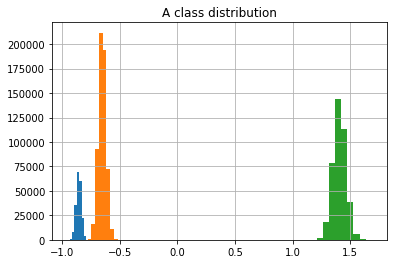

None


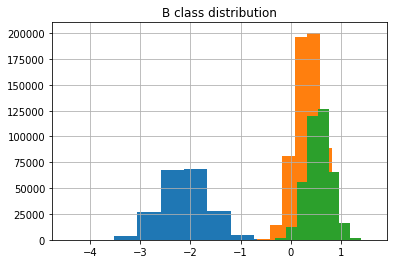

None


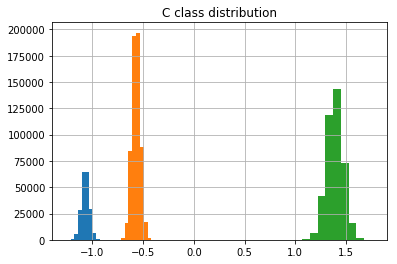

None


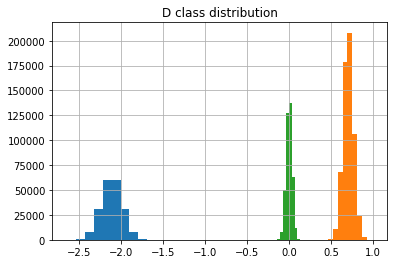

None


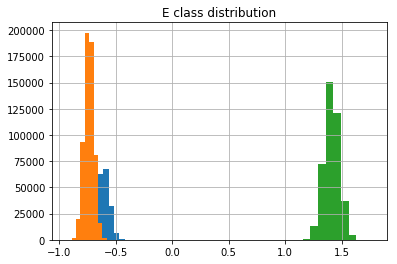

None


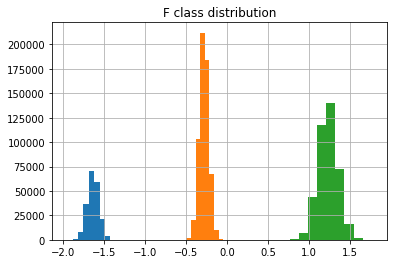

None


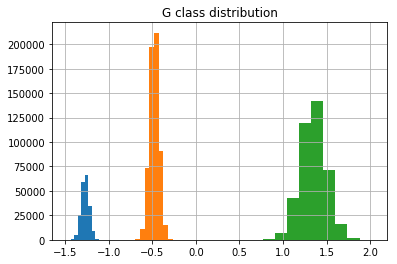

None


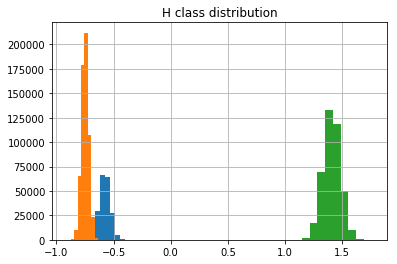

None


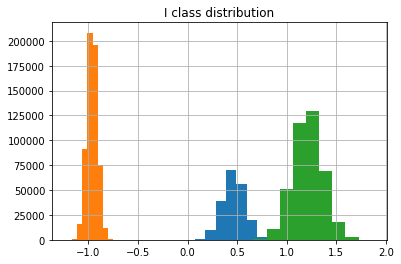

None


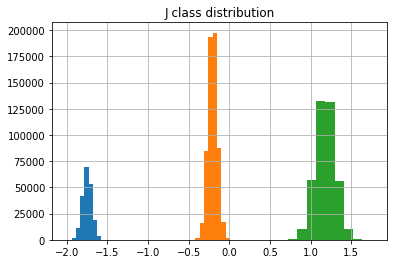

None


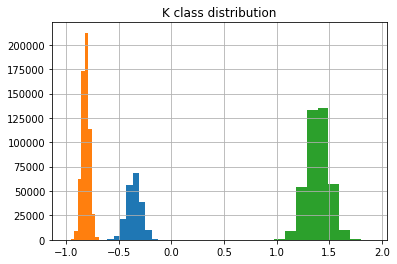

None


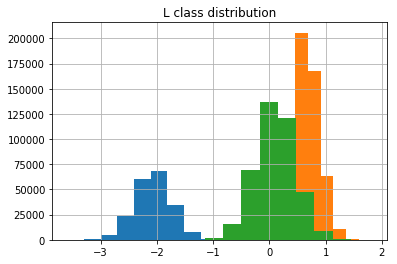

None


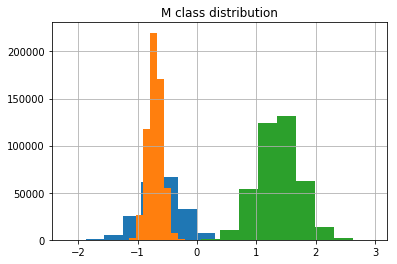

None


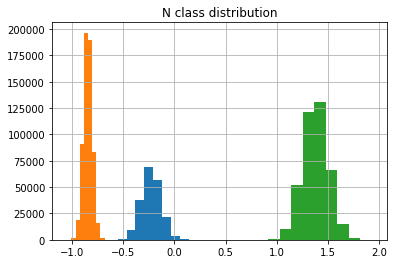

None


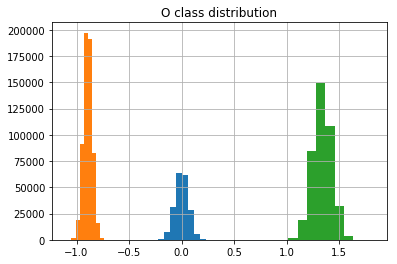

None


In [31]:
public_scaled_df = pd.concat([public_scaled,
                        public_data["Class"]],
                       axis=1)
for feature in public_scaled_df.drop(columns="Class").columns:
    public_scaled_df.groupby("Class")[feature].hist()
    plt.title(feature+ " class distribution")
    print(plt.show())



In [32]:
count = 0
matches = []
next_col = public_scaled.columns
for out in public_scaled.columns:
    class_squeeze = np.squeeze(np.asarray(public_data[out]))
    next_col = next_col.drop(out)
    for col in next_col:
        plen = np.squeeze(np.asarray(public_scaled[col]))
#         displen = np.dot(class_squeeze, plen)/(np.linalg.norm(class_squeeze)*(np.linalg.norm(plen)))
#         print(col,"x", out, str(displen))
#         print()
        if np.corrcoef(plen, class_squeeze)[0][1] > 0.98:
            count = count + 1
            matches.append(out + "x" + col)
        else:
            print(out,"x", col, np.corrcoef(plen, class_squeeze)[0][1])
print(count)
print(matches)

A x B 0.45594899913739995
A x D 0.07133038261793932
A x F 0.9053527491919926
A x G 0.9722228293725423
A x I 0.818399477866533
A x J 0.8700161418532376
A x K 0.9688268409718942
A x L 0.13961922160478893
A x M 0.9589305776748331
A x N 0.9530810727057415
A x O 0.9203218267294551
B x C 0.5417419491831306
B x D 0.8658557861095647
B x E 0.352945509847112
B x F 0.7607075034625481
B x G 0.6206066839190909
B x H 0.3395488747773573
B x I -0.09855774900748483
B x J 0.8032458316210619
B x K 0.24642852214341437
B x L 0.8546348126678589
B x M 0.3450300710350118
B x N 0.19457819994773715
B x O 0.09880504441797408
C x D 0.17622393427281127
C x E 0.971805425537075
C x F 0.9434815338787507
C x H 0.968342197464496
C x I 0.7534744977354667
C x J 0.9157843192415979
C x K 0.9378683341980713
C x L 0.23872344593839076
C x M 0.9410404838855062
C x N 0.916578204618697
C x O 0.8737999250049017
D x E -0.047458976260814675
D x F 0.47718279937971997
D x G 0.27924786217156206
D x H -0.062450906164409854
D x I -0.502

In [17]:
public_scaled = public_scaled.drop(columns = ["E", "H", "C", "G", "K", "N", "O", "J"])

In [18]:

count = 0
matches = []
next_col = public_scaled.columns
for out in public_scaled.columns:
    class_squeeze = np.squeeze(np.asarray(public_data[out]))
    next_col = next_col.drop(out)
    for col in next_col:
        plen = np.squeeze(np.asarray(public_scaled[col]))
#         displen = np.dot(class_squeeze, plen)/(np.linalg.norm(class_squeeze)*(np.linalg.norm(plen)))
#         print(col,"x", out, str(displen))
#         print()
        if np.corrcoef(plen, class_squeeze)[0][1] > 0.9:
            count = count + 1
            matches.append(out + "x" + col)
        else:
            print(out,"x", col, np.corrcoef(plen, class_squeeze)[0][1])

print(count)
print(matches)

A x B 0.45594899913739995
A x D 0.07133038261793932
A x I 0.818399477866533
A x L 0.13961922160478893
B x D 0.8658557861095647
B x F 0.7607075034625481
B x I -0.09855774900748483
B x L 0.8546348126678589
B x M 0.3450300710350118
D x F 0.47718279937971997
D x I -0.5026434510949506
D x M -0.04205688301850702
F x I 0.5083454264195518
F x L 0.5181168926181521
F x M 0.8235514707732727
I x L -0.41811033513211604
I x M 0.8488005802749112
L x M 0.029013289957726715
3
['AxF', 'AxM', 'DxL']


In [19]:
public_scaled = public_scaled.drop(columns = ["F", "M", "L"])

In [20]:

count = 0
matches = []
next_col = public_scaled.columns
for out in public_scaled.columns:
    class_squeeze = np.squeeze(np.asarray(public_data[out]))
    next_col = next_col.drop(out)
    for col in next_col:
        plen = np.squeeze(np.asarray(public_scaled[col]))
#         displen = np.dot(class_squeeze, plen)/(np.linalg.norm(class_squeeze)*(np.linalg.norm(plen)))
#         print(col,"x", out, str(displen))
#         print()
        if np.corrcoef(plen, class_squeeze)[0][1] > 0.9:
            count = count + 1
            matches.append(out + "x" + col)
        else:
            print(out,"x", col, np.corrcoef(plen, class_squeeze)[0][1])

print(count)
print(matches)

A x B 0.45594899913739995
A x D 0.07133038261793932
A x I 0.818399477866533
B x D 0.8658557861095647
B x I -0.09855774900748483
D x I -0.5026434510949506
0
[]


In [33]:
public_scaled.describe()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
count,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,-3.643659e-17,-2.155209e-16,2.813494e-16,1.553099e-16,7.729761e-17,-3.568016e-17,9.957905e-17,3.148870e-17,6.199393e-17,-1.551724e-16,9.179620e-17,2.122283e-16,-3.071542e-16,-1.836540e-16,-5.088456e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.576537e-01,-4.451873e+00,-1.247617e+00,-2.644705e+00,-9.302043e-01,-1.948346e+00,-1.475652e+00,-9.050405e-01,-1.213772e+00,-1.992491e+00,-9.862478e-01,-3.593717e+00,-2.184472e+00,-1.041432e+00,-1.087707e+00
25%,-6.856782e-01,6.686056e-02,-6.085477e-01,-2.478078e-02,-7.388438e-01,-3.357422e-01,-5.288938e-01,-7.487208e-01,-9.626425e-01,-2.579156e-01,-8.115155e-01,-1.366680e-01,-7.453553e-01,-8.415592e-01,-8.931280e-01
50%,-6.395787e-01,3.550282e-01,-5.521766e-01,1.182764e-01,-6.647971e-01,-2.540494e-01,-4.541885e-01,-6.701335e-01,1.112827e-01,-1.787165e-01,-5.572950e-01,3.638817e-01,-5.947576e-01,-5.182225e-01,-1.933404e-01
75%,1.371888e+00,5.723130e-01,1.336639e+00,7.059888e-01,1.365782e+00,1.156495e+00,1.252824e+00,1.358384e+00,1.110893e+00,1.097673e+00,1.320777e+00,6.472593e-01,1.129887e+00,1.291130e+00,1.277773e+00
max,1.687340e+00,1.610521e+00,1.752916e+00,9.848922e-01,1.765142e+00,1.766344e+00,2.016591e+00,1.758369e+00,1.856630e+00,1.749513e+00,1.902329e+00,1.819692e+00,2.939533e+00,1.923838e+00,1.810468e+00


Text(0, 0.5, 'explained_variance_')

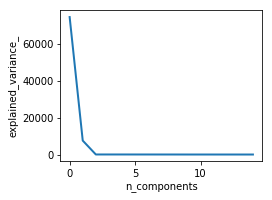

In [34]:

pca = decomposition.PCA()
pca.fit(public_data.drop(columns="Class"))

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')


In [29]:
print(pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1])

0.9038957562541423 0.09177111360829747


## Model Training - Feature engineering, evaluation metrics, model selection
I am using kfold validation to evaluate my models. I am using a k = 5 because the book mentions that k of 5 and k of 10 are the most common to use. My model uses PCA to extract 4 new components to fit into the pipeline. Once the dataset is run through the PCA they enter the Random Forest. This problem deals with classification and choosing between Random Forest and Decision Trees was a hard choice. I decided to use Random Forest as my classifier because it doesn't as easily overfit the data. This is especially true when a large number of trees are used. I choose 20 trees because the more trees used the less the model overfits on the dataset used in training. Since we already know that our dataset is problematic I choose to generate 20 trees even though it does take longer to run the model. I used kfold validation to determine what model to choose and what to train it on. My main metrics was too look for a high fscore and high TPR and FPR. The model that I choose had a 100% fscore and 100% TPR and 0% FPR. I realize that this is an ideal score but consdering that I already had split my data before I performed cross validation on my training set I was pretty confident that the metrics that I got from the test set were pretty good. Thus I choose my model to have a pipeline of PCA with 4 components and a Random Forest with 20 trees. Confident that the classification metrics on the reserved test set are solid.



In [40]:
preprocessor = decomposition.PCA(n_components=4)
classifier = RandomForestClassifier(n_estimators=20, max_depth=2, random_state=0)
pipeline = Pipeline(steps=[
    ('preprocessor',
    preprocessor),
    ('classifier',
     classifier)
])


In [41]:
data_train, data_test, target_train, target_test = train_test_split(public_data.drop(columns=["Class"]),
                                                   public_data["Class"],
                                                 test_size=0.3)

In [42]:
l = []
for train_index, test_index in KFold(5).split(data_train):
    print("Train", train_index, "Test", test_index)
    X_train, X_test = data_train.values[train_index], data_train.values[test_index]
    y_train, y_test = target_train.values[train_index], target_train.values[test_index]
    l.append((train_index, test_index))
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    print(metrics.classification_report(y_test,
                                    pred))
    cmatrix = metrics.confusion_matrix(y_test,pred)
    FP = cmatrix.sum(axis=0) - np.diag(cmatrix)  
    FN = cmatrix.sum(axis=1) - np.diag(cmatrix)
    TP = np.diag(cmatrix)
    TN = cmatrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    print("TPR", np.mean(TPR), "FPR", np.mean(FPR), "Ratio", np.mean(TPR)/np.mean(FPR))
    


Train [168000 168001 168002 ... 839997 839998 839999] Test [     0      1      2 ... 167997 167998 167999]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27945
           2       1.00      1.00      1.00     83953
           3       1.00      1.00      1.00     56102

   micro avg       1.00      1.00      1.00    168000
   macro avg       1.00      1.00      1.00    168000
weighted avg       1.00      1.00      1.00    168000



/home/mahmoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


TPR 1.0 FPR 0.0 Ratio inf
Train [     0      1      2 ... 839997 839998 839999] Test [168000 168001 168002 ... 335997 335998 335999]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27761
           2       1.00      1.00      1.00     84078
           3       1.00      1.00      1.00     56161

   micro avg       1.00      1.00      1.00    168000
   macro avg       1.00      1.00      1.00    168000
weighted avg       1.00      1.00      1.00    168000



/home/mahmoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


TPR 1.0 FPR 0.0 Ratio inf
Train [     0      1      2 ... 839997 839998 839999] Test [336000 336001 336002 ... 503997 503998 503999]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     28100
           2       1.00      1.00      1.00     83963
           3       1.00      1.00      1.00     55937

   micro avg       1.00      1.00      1.00    168000
   macro avg       1.00      1.00      1.00    168000
weighted avg       1.00      1.00      1.00    168000



/home/mahmoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


TPR 1.0 FPR 0.0 Ratio inf
Train [     0      1      2 ... 839997 839998 839999] Test [504000 504001 504002 ... 671997 671998 671999]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27987
           2       1.00      1.00      1.00     84212
           3       1.00      1.00      1.00     55801

   micro avg       1.00      1.00      1.00    168000
   macro avg       1.00      1.00      1.00    168000
weighted avg       1.00      1.00      1.00    168000



/home/mahmoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


TPR 1.0 FPR 0.0 Ratio inf
Train [     0      1      2 ... 671997 671998 671999] Test [672000 672001 672002 ... 839997 839998 839999]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     28194
           2       1.00      1.00      1.00     84083
           3       1.00      1.00      1.00     55723

   micro avg       1.00      1.00      1.00    168000
   macro avg       1.00      1.00      1.00    168000
weighted avg       1.00      1.00      1.00    168000

TPR 1.0 FPR 0.0 Ratio inf


/home/mahmoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


In [39]:
my_train_indices = l[0][0]

In [37]:
preprocessor = decomposition.PCA(n_components=2)

classifier = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
pipeline = Pipeline(steps=[
    ('preprocessor',
    preprocessor),
    ('classifier',
     classifier)
])


In [38]:
l = []
for train_index, test_index in KFold(5).split(data_train):
    print("Train", train_index, "Test", test_index)
    X_train, X_test = data_train.values[train_index], data_train.values[test_index]
    y_train, y_test = target_train.values[train_index], target_train.values[test_index]
    l.append((train_index, test_index))
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    print(metrics.classification_report(y_test,
                                    pred))
    cmatrix = metrics.confusion_matrix(y_test,pred)
    FP = cmatrix.sum(axis=0) - np.diag(cmatrix)  
    FN = cmatrix.sum(axis=1) - np.diag(cmatrix)
    TP = np.diag(cmatrix)
    TN = cmatrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    print("TPR", np.mean(TPR), "FPR", np.mean(FPR), "Ratio", np.mean(TPR)/np.mean(FPR))
    


Train [168000 168001 168002 ... 839997 839998 839999] Test [     0      1      2 ... 167997 167998 167999]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27942
           2       1.00      1.00      1.00     83902
           3       1.00      1.00      1.00     56156

   micro avg       1.00      1.00      1.00    168000
   macro avg       1.00      1.00      1.00    168000
weighted avg       1.00      1.00      1.00    168000



/home/mahmoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


TPR 1.0 FPR 0.0 Ratio inf
Train [     0      1      2 ... 839997 839998 839999] Test [168000 168001 168002 ... 335997 335998 335999]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     28196
           2       1.00      1.00      1.00     83754
           3       1.00      1.00      1.00     56050

   micro avg       1.00      1.00      1.00    168000
   macro avg       1.00      1.00      1.00    168000
weighted avg       1.00      1.00      1.00    168000



/home/mahmoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


TPR 1.0 FPR 0.0 Ratio inf
Train [     0      1      2 ... 839997 839998 839999] Test [336000 336001 336002 ... 503997 503998 503999]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27780
           2       1.00      1.00      1.00     84027
           3       1.00      1.00      1.00     56193

   micro avg       1.00      1.00      1.00    168000
   macro avg       1.00      1.00      1.00    168000
weighted avg       1.00      1.00      1.00    168000



/home/mahmoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


TPR 1.0 FPR 0.0 Ratio inf
Train [     0      1      2 ... 839997 839998 839999] Test [504000 504001 504002 ... 671997 671998 671999]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27808
           2       1.00      1.00      1.00     84284
           3       1.00      1.00      1.00     55908

   micro avg       1.00      1.00      1.00    168000
   macro avg       1.00      1.00      1.00    168000
weighted avg       1.00      1.00      1.00    168000



/home/mahmoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


TPR 1.0 FPR 0.0 Ratio inf
Train [     0      1      2 ... 671997 671998 671999] Test [672000 672001 672002 ... 839997 839998 839999]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     28131
           2       1.00      1.00      1.00     84062
           3       1.00      1.00      1.00     55807

   micro avg       1.00      1.00      1.00    168000
   macro avg       1.00      1.00      1.00    168000
weighted avg       1.00      1.00      1.00    168000

TPR 1.0 FPR 0.0 Ratio inf


/home/mahmoud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


In [33]:
preprocessor = Pipeline(steps=[
    ('PCA',
     decomposition.PCA()),
    ('scaler',
     StandardScaler())
])
classifier = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
pipeline = Pipeline(steps=[
    ('preprocessor',
    preprocessor),
    ('classifier',
     classifier)
])

In [34]:
l = []
for train_index, test_index in KFold(5).split(data_train):
    print("Train", train_index, "Test", test_index)
    X_train, X_test = data_train.values[train_index], data_train.values[test_index]
    y_train, y_test = target_train.values[train_index], target_train.values[test_index]
    l.append((train_index, test_index))
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    print(metrics.classification_report(y_test,
                                    pred))
    cmatrix = metrics.confusion_matrix(y_test,pred)
    FP = cmatrix.sum(axis=0) - np.diag(cmatrix)  
    FN = cmatrix.sum(axis=1) - np.diag(cmatrix)
    TP = np.diag(cmatrix)
    TN = cmatrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    print("TPR", np.mean(TPR), "FPR", np.mean(FPR), "Ratio", np.mean(TPR)/np.mean(FPR))
    


Train [ 240000  240001  240002 ... 1199997 1199998 1199999] Test [     0      1      2 ... 239997 239998 239999]
              precision    recall  f1-score   support

           1       1.00      0.00      0.00     40115
           2       1.00      1.00      1.00    120110
           3       0.67      1.00      0.80     79775

   micro avg       0.83      0.83      0.83    240000
   macro avg       0.89      0.67      0.60    240000
weighted avg       0.89      0.83      0.77    240000

TPR 0.6668910216461009 FPR 0.08339938627971083 Ratio 7.996354066796536
Train [      0       1       2 ... 1199997 1199998 1199999] Test [240000 240001 240002 ... 479997 479998 479999]
              precision    recall  f1-score   support

           1       1.00      0.09      0.17     40204
           2       0.88      1.00      0.94    120041
           3       0.80      1.00      0.89     79755

   micro avg       0.85      0.85      0.85    240000
   macro avg       0.89      0.70      0.66    240

## Model Validation - Testing results, performance criteria, biases/risks
The models testing results are really good. The model is giving me a fscore of 1 and 100% True Positive Rate and 0% False Positive Rate. The biases that follow with using the data that we have to train the model can lead to overfitting especially since the data expresses strange patterns. It seems that the data is very homogenous and isn't very representative of the population. The high correlation between the features and the class lead to the model being overfitted for this specific dataset.  

In [49]:
X_train, X_test = data_train.values[my_train_indices], data_test
y_train, y_test = target_train.values[my_train_indices], target_test

In [53]:
pd_xtrain = pd.DataFrame(X_train, columns=data_train.columns)
pd_ytrain = pd.DataFrame(y_train, columns=["Class"])
pub_train = pd.concat([pd_xtrain,
                        pd_ytrain],
                       axis=1)
pub_train.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,-37.550799,-8.712215,9.133864,17.788328,-28.357000,-29.265105,-2.763102,-27.961450,-8.553221,17.913225,5.282540,-0.435865,-57.995173,-4.883147,-1.327732,2
1,-27.829048,-14.130431,9.037911,20.297458,-19.612548,-26.945718,-0.053396,-24.209625,-8.468128,24.505171,5.405890,11.777350,-55.227240,-6.983454,-2.190366,2
2,-26.696217,-12.596979,14.582814,16.869124,-24.192273,-28.699077,1.063033,-35.458667,-8.327425,30.355786,-0.382990,1.900576,-56.630381,-2.797531,3.156694,2
3,-36.737883,-11.188791,8.439719,20.555723,-22.757601,-21.277989,2.172978,-27.716255,-6.565886,26.641757,6.162232,2.465152,-56.643885,-3.692401,-7.532692,2
4,235.596328,-10.655889,226.897029,-11.988357,128.102546,86.054199,113.616872,203.377657,84.875998,138.228102,225.237864,-8.014168,-14.493232,132.363027,143.865274,3


In [54]:
pub_train.describe()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
count,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000,672000.000000
mean,50.525268,-18.832906,71.492735,-13.527466,29.347490,-6.256262,31.672198,50.984979,32.937747,40.865824,79.246846,-6.732587,-42.339880,49.396782,59.712785,2.166042
std,129.190136,14.464993,105.230640,46.895533,72.788486,73.049501,66.566010,103.362730,42.161295,76.921441,94.800054,15.574137,17.909028,67.261737,66.751650,0.686972
min,-73.089401,-83.223570,-59.396519,-137.490156,-38.298257,-148.591728,-64.477157,-42.460894,-17.705980,-112.384444,-14.152332,-62.718276,-80.393454,-20.309609,-12.762138,1.000000
25%,-37.944022,-17.863878,7.550170,-14.717010,-24.362737,-30.734880,-3.483618,-26.310379,-7.601574,21.089268,2.404117,-8.860204,-55.676535,-7.137705,0.164628,2.000000
50%,-31.992405,-13.694468,13.473164,10.591813,-18.994289,-24.760462,1.489937,-18.297642,-0.898131,27.169660,12.717691,-1.066143,-52.983461,1.843428,8.847949,2.000000
75%,227.980620,-10.560160,212.275156,19.559539,128.875443,78.291052,115.140273,191.559137,79.830577,125.345913,204.593454,3.344238,-22.100853,136.346344,145.094506,3.000000
max,266.161237,4.457411,256.169843,32.223447,153.052475,122.918640,166.053416,232.949604,110.804605,175.539703,257.356521,21.594956,10.328284,177.758080,174.992017,3.000000


In [55]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,...imators=20, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [56]:
predicted = pipeline.predict(X_test)
print(metrics.classification_report(y_test,
predicted))
print(metrics.confusion_matrix(y_test,
                               predicted))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     60116
           2       1.00      1.00      1.00    179542
           3       1.00      1.00      1.00    120342

   micro avg       1.00      1.00      1.00    360000
   macro avg       1.00      1.00      1.00    360000
weighted avg       1.00      1.00      1.00    360000

[[ 60116      0      0]
 [     0 179542      0]
 [     0      0 120342]]


In [57]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,...imators=20, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [58]:
input_types = [('float', FloatTensorType([1, 1]))]
try:
    model_onnx = convert_sklearn(pipeline,
                                 'pipeline_onnx',
                                initial_types=input_types)
except Exception as e:
    print(e)

with open("pipeline.onnx", "wb") as f:
     f.write(model_onnx.SerializeToString())

The maximum opset needed by this model is only 1.


In [59]:
#inputs_onnx = {k: array(v).astype(np.float32)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}
#print(inputs_onnx)
#print(len(inputs_onnx))
#tmp = X_test["I"]
#print(X_test.describe())
#inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in tmp.to_dict(orient='list').items()}

session_onnx = rt.InferenceSession("pipeline.onnx")
for i in session_onnx.get_inputs():
    print('Input', i)
for k in session_onnx.get_outputs():
    print('Output', k)
predict_onnx = session_onnx.run(None, {'float': X_test.values.astype(np.float32)})
print("predict", predict_onnx[0])

Input NodeArg(name='float', type='tensor(float)', shape=[1, 1])
Output NodeArg(name='output_label', type='tensor(int64)', shape=[1])
Output NodeArg(name='output_probability', type='seq(map(int64,tensor(float)))', shape=[])
predict [2 3 3 ... 3 2 2]


In [61]:
print(metrics.classification_report(y_test,
                                    predict_onnx[0]))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     60116
           2       1.00      1.00      1.00    179542
           3       1.00      1.00      1.00    120342

   micro avg       1.00      1.00      1.00    360000
   macro avg       1.00      1.00      1.00    360000
weighted avg       1.00      1.00      1.00    360000



(-0.5, 1947.5, 3497.5, -0.5)

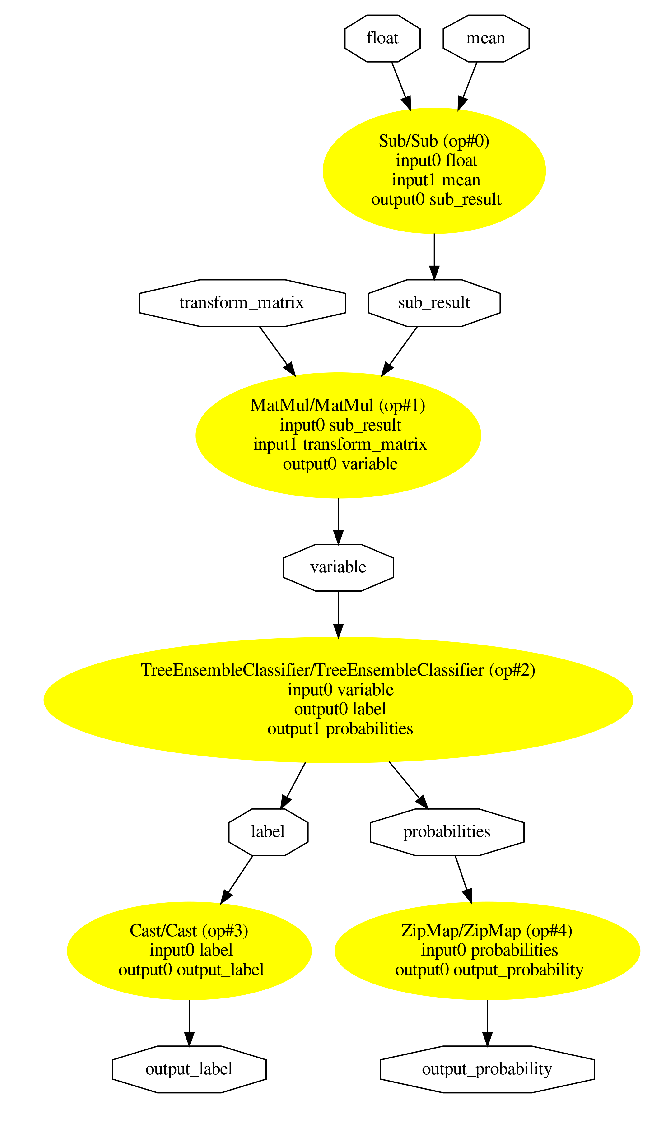

In [62]:
pydot_graph = GetPydotGraph(model_onnx.graph,
                            name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="yellow",
                                                            fillcolor="yellow",
                                                            style="filled"))
pydot_graph.write_dot("iris_pipeline.dot")

os.system('dot -O -Gdpi=300 -Tpng iris_pipeline.dot')

image = plt.imread("iris_pipeline.dot.png")
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(image)
ax.axis('off')

## Conclusion - Positive/Negative results, recommendations, caveats/cautions.
The conclusion from this project is that the data is highly skewed and homogenous. Considering that most of the features correlate to the target class we have a biased dataset that will generate a highly overfitted model. Even with the measures taken to minimize the overfitting factors like using a random forest with 20 trees we still run into the problem that with the size of the dataset we will probably overfit. Also the assumption that the variance of the dataset is representative of the population can be misleading. So far it has worked for us when we divide the dataset into 30/70 test/train sets. But outside sample data could have a different variance direction that can make the model inefficient. The best thing to do is get a more representative dataset to train your data. In conclusion the model could be more efficientally tuned if the dataset provide was a solid dataset.


- Data Sources - Links, downloads, access information.•

https://machinelearningmastery.com/k-fold-cross-validation/
https://scikit-learn.org/0.18/auto_examples/plot_digits_pipe.html
https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd
https://matplotlib.org/gallery/pyplots/pyplot_text.html#sphx-glr-gallery-pyplots-pyplot-text-py